## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [19]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [20]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [21]:
import findspark
findspark.init()

from pyspark import SparkContext
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [22]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [23]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
5
+--------------------+-------------------+--------------------+---------+--------+--------+---------+-----------+------------------+--------------------+--------------------+------------------+-----------+---------+------+--------------------+------+
|             coeff_1|            coeff_2|             coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|               res_2|               res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+--------------------+-------------------+--------------------+---------+--------+--------+---------+-----------+------------------+--------------------+--------------------+------------------+-----------+---------+------+--------------------+------+
| -0.2656756822576242|0.15252683786513813| -50.968086219487844|     19.8|BSBSSSBS| 29.8286| -82.5972|       SNWD|0.9999728299027855|  0.9999638746032488|1.701309635881318E-7|0

In [24]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(5)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+--------------------+
|    station|latitude|longitude|elevation|             coeff_1|
+-----------+--------+---------+---------+--------------------+
|USC00083956| 29.8286| -82.5972|     19.8| -0.2656756822576242|
|USC00083321| 29.6333| -82.3667|     29.3|-0.37874281838369617|
|USC00083321| 29.6333| -82.3667|     29.3|   419.7233289657358|
|USC00086065| 27.2417| -82.3161|      6.1|-0.26268104335751274|
|USC00086414| 29.1636| -82.0778|     22.9| -0.2636149329510031|
+-----------+--------+---------+---------+--------------------+



In [25]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
print pdf
pdf.head(2)

       station  latitude  longitude  elevation  count(station)  avg(coeff_1)
1  USC00083321   29.6333   -82.3667       29.3               2    209.672293
0  USC00083956   29.8286   -82.5972       19.8               1     -0.265676
2  USC00086065   27.2417   -82.3161        6.1               1     -0.262681
3  USC00086414   29.1636   -82.0778       22.9               1     -0.263615


,station,latitude,longitude,elevation,count(station),avg(coeff_1)
1,USC00083321,29.6333,-82.3667,29.3,2,209.672293
0,USC00083956,29.8286,-82.5972,19.8,1,-0.265676


In [26]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [27]:
min_lat,max_lat,min_long,max_long = box = (26.0000, 31.000, -81.70, -83.0)


In [28]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    print _coef
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(5000*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

209.672293074
-0.265675682258
-0.262681043358
-0.263614932951


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

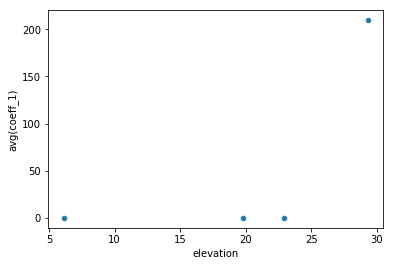

In [12]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [13]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']